# **Analysis of Configurations**

### **Frame complexity**

In [49]:
import skimage.measure   
import cv2
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
import os


In [52]:
file = '../test_results/config_testing/resolution/'
stats = 'stats/'
column_order = ['Video', 'Width (px)', 'Height (px)', 'Frame Rate (fps)']
dfs = []

def get_average_size(df_path, x_res, y_res):
    average_size = 0
    df = pd.read_csv(df_path, index_col=0)
    
    for row in df.iterrows():
        average_size += (row[1][2] * row[1][3])
    
    average_size /= len(df)
    
    return average_size


for video in list(os.listdir(os.path.join(file, 'stats/'))):
    file_name = '_'.join(os.path.splitext(video)[0].split('_')[0:-1]) # Get file name
    stats = os.path.join(file, 'stats/', file_name + '_stats.txt')
    inference = os.path.join(file, 'inference/', file_name + '_inference.csv')
    energy = os.path.join(file, 'energy/', file_name + '_energy.csv')

    df = pd.read_csv(stats, \
            sep=': ', header=None, engine='python').set_index(0)
    df = df.transpose().reset_index(drop=True)

    config_params = os.path.basename(stats).split('_')
    
    if config_params[0] in ['large3', 'large5'] or int(config_params[3]) != 5:
        continue
    # if int(config_params[3]) == 25:
    #     continue
    
    # Setting columns based on params
    df['Video'] = f'{config_params[0]}'
    df['Width (px)'], df['Height (px)'], df['Frame Rate (fps)'] = \
    config_params[1], config_params[2], config_params[3]
    df = df.astype({'Width (px)': int, 'Height (px)': int})

    # Add columns
    df['Resolution (px)'] = df['Width (px)'].multiply(df['Height (px)'])
    df['Resolution (1000s of px)'] = df['Resolution (px)'] / 1000
    df['Energy (1000s of J)'] = df['energy'] / 1000
    df['Energy (J) per frame'] = df['energy'] / 250

    # Count # of detections
    with open(inference, 'r') as f:
        lines = f.readlines()
        df['Detections'] = len(lines) - 1  # subtract the first line, which is cols of df
    
    # Average object size
    df['Average detection size'] = get_average_size(inference, df['Width (px)'], df['Height (px)'])
                
    df = df.reindex(columns=column_order+[x for x in df.columns if x not in column_order])
    dfs.append(df)

out = pd.concat(dfs)

In [51]:
means = df.mean().reset_index()

TypeError: Could not convert ['sparse'] to numeric

In [46]:
diff = pd.DataFrame()
for video in np.unique(out['Video']):
    sub = out.loc[out['Video'] == video]
    diff[video] = sub.loc[sub['Width (px)'] == 960]['mAP'] - sub.loc[sub['Width (px)'] == 640]['mAP'] 
    

In [48]:
merged = pd.merge(diff.transpose().reset_index(), pd.DataFrame(means[diff.columns]).reset_index(), on='index')

KeyError: "None of [Index(['large4', 'largeslow', 'largeslow2', 'medium', 'noisy', 'smallslow2',\n       'sparse'],\n      dtype='object')] are in the [columns]"

([0, 1, 2, 3, 4, 5, 6, 7, 8, 9, 10, 11, 12],
 [Text(0, 0, 'large3'),
  Text(1, 0, 'large4'),
  Text(2, 0, 'large5'),
  Text(3, 0, 'largeslow2'),
  Text(4, 0, 'largeslow'),
  Text(5, 0, 'medium'),
  Text(6, 0, 'noisy'),
  Text(7, 0, 'smallslow2'),
  Text(8, 0, 'sparse'),
  Text(9, 0, 'large2'),
  Text(10, 0, 'largefast'),
  Text(11, 0, 'smallfast'),
  Text(12, 0, 'smallslow')])

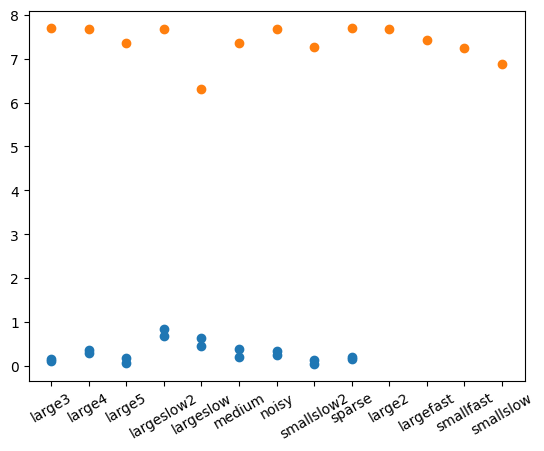

In [55]:
fig, ax = plt.subplots()

ax.scatter(config_data['Test Video'], config_data['mAP'])
ax.scatter(means.index, means)
plt.xticks(rotation=30)